# SCA through Dino LFP data

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ldliao/Research/Projects/spectralCA/')
sys.path.append('/Users/ldliao/Research/Projects/spectralCA/notebooks_visualization/')
# sys.path.append('/Users/Lauren/Voytek/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCA')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
# sys.path.append('/Users/rdgao/Documents/code/research/fooof/')

In [3]:
import os
#path = '/Users/ldliao/Research/Projects/spectralCA/results/dino/'

#os.chdir(path) # DONT CHANGE PATH INSIDE THE NOTEBOOK, YOU"LL GET LOST. USE FULL PATH
import glob
from sca import sca
import neurodsp as ndsp

# the final product to import the visualization
from sca import sca_vis

Loading BokehJS ...

In [4]:
%matplotlib inline

# imports
# from sca import access_nt as asc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd

import neurodsp as ndsp
# from fooof import FOOOFGroup
# import sca

In [5]:
data_path = "/Users/ldliao/Research/Data/Dino/Dino_072114_mPFC_ephys.mat"
data_path = "/Users/rdgao/Documents/data/CRCNS/fcx1/Dino_072114_mPFC/Dino_072114_mPFC_ephys.mat"
dino = io.loadmat(data_path, squeeze_me=True)

In [6]:
info_path = "/Users/ldliao/Research/Data/Dino/Dino_072114_mPFC_wakesleep.csv"
info_path = "/Users/rdgao/Documents/data/CRCNS/fcx1/Dino_072114_mPFC/Dino_072114_mPFC_wakesleep.csv"
info = pd.read_csv(info_path,index_col='Unnamed: 0')

In [7]:
info[-3:]

,Label,Start,Inter,End
175,Wake,5,NaN,3361
176,Sleep,3361,NaN,4992
177,WakeSleep,5,3361.0,4992


In [105]:
label = 'Wake'
duration = list(zip(info[info['Label'] == label]['Start'].values, info[info['Label'] == label]['End'].values))
fs = 1250
analysis_param = {'nperseg': int(fs),
                 'noverlap': 0,
                 'spg_outlierpct': 4.,
                 'max_freq':200}

data = []
for dur in duration:
    start, end = dur
    
    # don't append like this because there will be a gap if there are multiple trials
    # of the same type. Compute sca separately
    data.append(dino['lfp'][:,start*fs:end*fs])
    
data = np.column_stack(data)

In [106]:
# initialize object with data and parameters
dino_sca = sca.SCA(analysis_param)
dino_sca.populate_ts_data(data, fs)

# compute all spectral attributes
dino_sca.compute_all_spectral()

# compute KS-test fit against null exponential hypothesis
dino_sca.compute_KS_expfit() # this takes a few minutes

chan_count, freq = dino_sca.psd.shape
chan_labels = list(map(str, range(chan_count)))

In [107]:
dino_sca.chan_labels = ['chan_'+chan for chan in chan_labels]
# save out
dino_sca.save_spec_vars('../results/dino/'+label.lower(), save_spg=True)

In [108]:
dino_sca.cross_freq_corr()

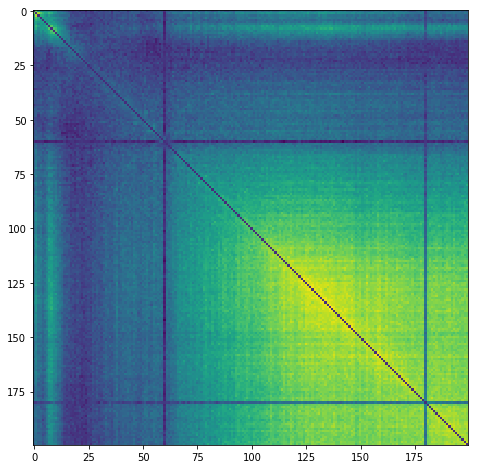

In [109]:
plt.figure(figsize=(8,8))
plt.imshow(dino_sca.pow_corrmat[3])
# pairwise k-means correlation structure

In [116]:
freq_lag = 1
spg_norm = dino_sca.spg/abs(dino_sca.spg)
dph = (spg_norm[:, :-freq_lag,:]/spg_norm[:,freq_lag:,:])
apc = (abs(dph.mean(-1))[:,1:]+abs(dph.mean(-1))[:,:-1])/2
self_apc = np.zeros_like(dino_sca.psd)
self_apc[:,freq_lag:] = apc
plt.semilogx(dino_sca.f_axis,self_apc[0])

ValueError: could not broadcast input array from shape (4,198) into shape (4,199)